In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

#### CONSTANTS
Always avoid magic numbers. 

In [120]:
WEEKDAYS_IN_YEAR = 261
QUARTERS_IN_YEAR = 4

# Question 1

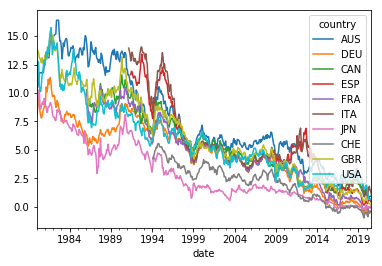

In [2]:
LongRates = dl.pull("LongRates")
LongRates.plot()

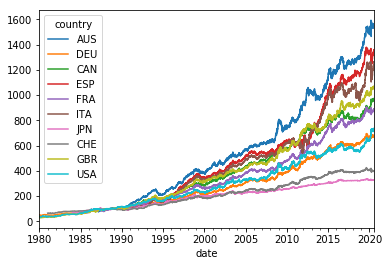

In [3]:
BondReturns = dl.pull("BondRetIdx/LocalFX")
BondReturns.plot()

The countries that have produced the lowest yield are Japan and Switzerland. The countries that have produced the highest yield are Australia and Spain. 

# Question 2


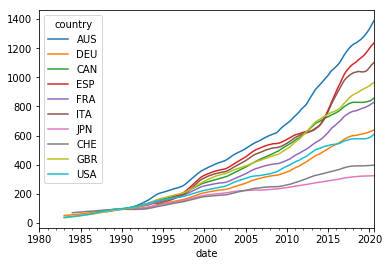

In [187]:
BondReturns = dl.pull("BondRetIdx/LocalFX")
BondReturnsRollingMean = BondReturns.rolling(3*WEEKDAYS_IN_YEAR).mean() 
BondReturnsRollingMean.plot()

Australian bond returns significantly exceeded returns for the rest of the developed world in the early 1990s. We can see when we plot the short rates that there was significant decline in the interest rates in Australia in the early 1990s, likely causing bond prices to increase.

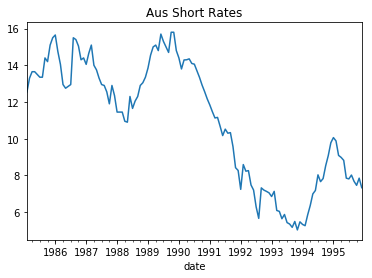

In [168]:
ShortRates = dl.pull("ShortRates")
mask = (ShortRates.index > '1985-1-1') & (ShortRates.index < '1996-1-1')
ShortRates['AUS'].loc[mask].plot(title="Aus Short Rates")

Japanese bond returns have lagged an average for a long time. When we plot the short rates in Japan, we see that they have been negative for the past 5 years. When interest rates are so low, fixed income investments (like bonds) offer very little to investors, hence how poor the returns from Japanese bonds are. 

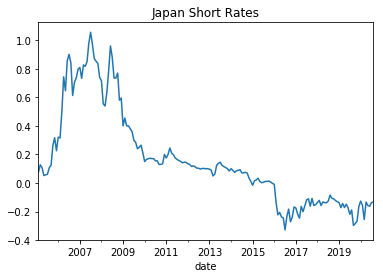

In [166]:
ShortRates = dl.pull("ShortRates")
mask = (ShortRates.index > '2005-1-1') & (ShortRates.index < '2021-1-1')
ShortRates['JPN'].loc[mask].plot(title="Japan Short Rates")

# Question 3


In [195]:
# Calculate our hedged returns every month (subtract 0.2% fee). 
BondReturnsMonthly = BondReturns.resample('M').mean().pct_change()
hedged = BondReturnsMonthly - (0.2 / 100)

In [196]:
# Pull the change in exchange rates (relative to USD). 
FxVsUSD = dl.pull("FxVsUSD")
FxPctChange = FxVsUSD.pct_change()

In [197]:
# Calculate our unhedged returns by factoring in changes in currency. 
currencyReturns = (1 + FxPctChange) * (1 + BondReturnsMonthly) - 1
unhedged = BondReturnsMonthly + currencyReturns

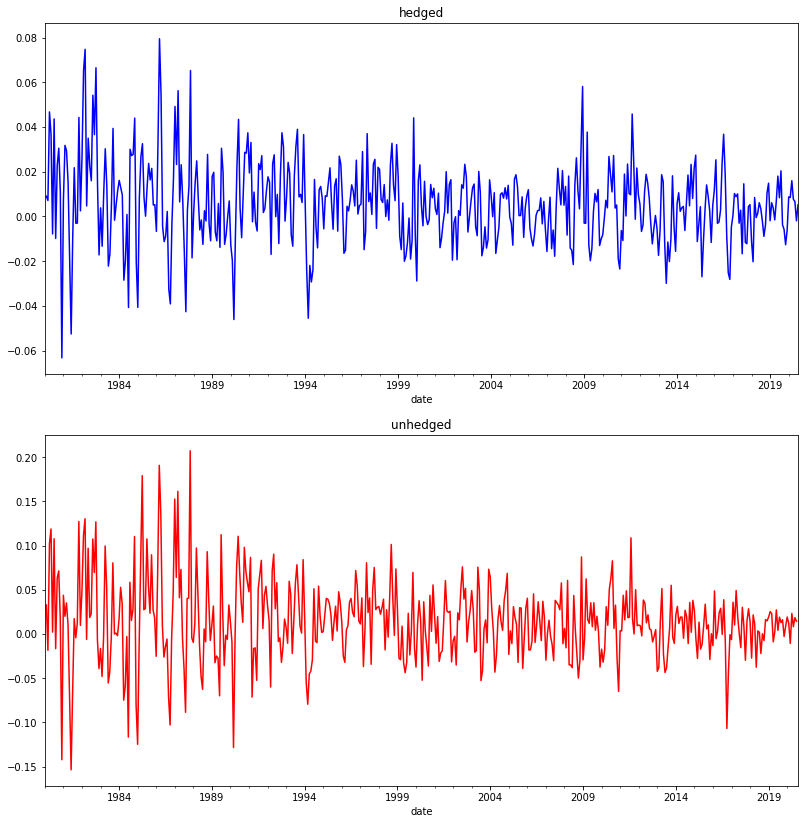

In [198]:
# Plot the hedged and unhedged returns. 
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.tight_layout(pad=4)
hedged['GBR'].plot(ax=axs[0], title="hedged", color="blue")
unhedged['GBR'].plot(ax=axs[1], title="unhedged", color="red")

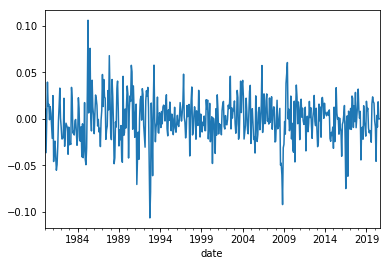

In [201]:
FxVsUSD['GBR'].pct_change().plot()

# Question 4

In [10]:
EquityPrices = dl.pull("EquityPrices")

Calculate the returns on a 60/40 stocks/bonds strategy. 

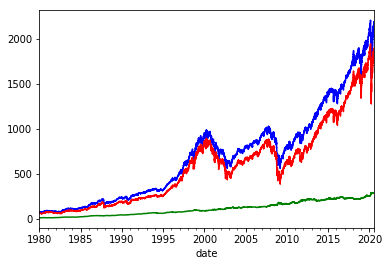

In [203]:
Strategy = 0.6 * EquityPrices['USA'] + 0.4 * BondReturns['USA']
Strategy.plot(color='blue')
(0.6 * EquityPrices['USA']).plot(color='red')
(0.4 * BondReturns['USA']).plot(color='green')

Calculate the average annual return on this strategy. (Pretend our final return value is the 2021)

In [204]:
YearBeginnings = Strategy.groupby(pd.Grouper(freq='Y')).nth(0)
lastRow = pd.Series(data=[Strategy.iloc[-1]], index=["2021"])
YearBeginnings = YearBeginnings.append(lastRow)

In [205]:
YearlyReturns = YearBeginnings.pct_change()

Average annual returns: 

In [206]:
str(YearlyReturns.mean() * 100) + "%"

'9.360316895796762%'

In [207]:
str(YearlyReturns.std())

'0.1351466798060128'

Get the Sharpe ratio of this strategy. 

In [209]:
AnnualShortRates = ShortRates.resample('1Y').mean()
ReturnsMinusRiskFree = YearlyReturns - AnnualShortRates['USA'] / 100
sharpe = ReturnsMinusRiskFree.mean() / YearlyReturns.std()
print("sharpe:", sharpe)

sharpe: 0.3502439279064035


# Question 5
Australia doesn't have M2 data. How should we build a standardized set of data? 


M1, M2, and M3 are different measures of the money supply. 
From Investopedia: 
- M1 includes coins and notes that are in circulation and other money equivalents that can be converted easily to cash. 
- M2 includes M1 and, in addition, short-term time deposits in banks and certain money market funds.
- M3 includes M2 in addition to long-term deposits. However, M3 is no longer included in the reporting by the Federal Reserve.

In [159]:
m1 = dl.pull("M1/inUSD")
m2 = dl.pull("M2/inUSD")
m3 = dl.pull("M3/inUSD")

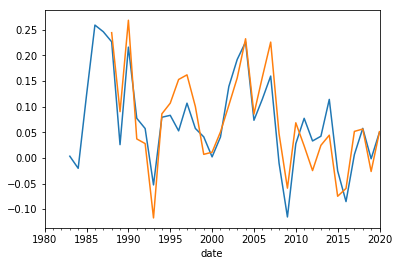

In [160]:
# Let's calculate m2 and m3 yearly change. 
m2_yearly = m2.resample('Y').mean()
m2_yearly_change = m2_yearly.pct_change()
m3_yearly = m3.resample('Y').mean()
m3_yearly_change = m3_yearly.pct_change()

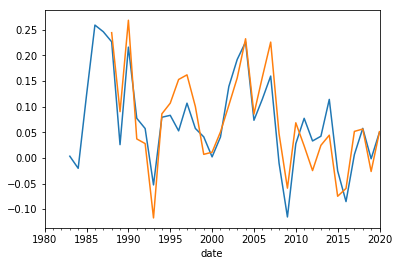

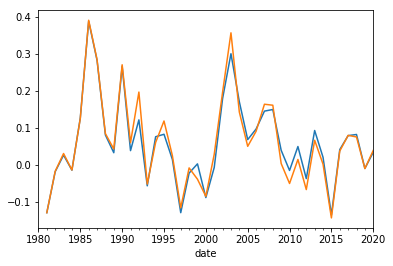

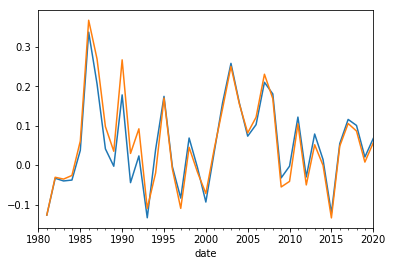

In [162]:
# Let's plot m2 and m3 curves for some countries, and see what we get. 
countries = ['GBR', 'ITA', 'FRA']
for c in countries: 
    m2_yearly_change[c].plot()
    m3_yearly_change[c].plot()
    plt.show()

In [210]:
# Calculate the correlation of the various money supplies as an additional tool to justify the choice of m3

# Question 6

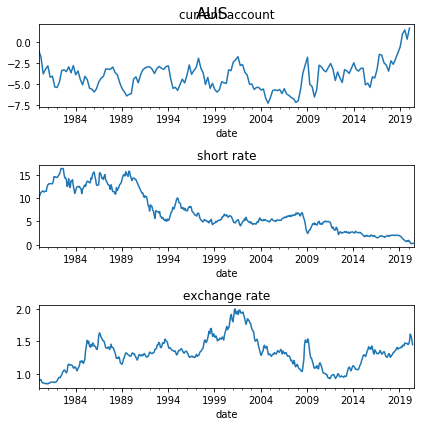

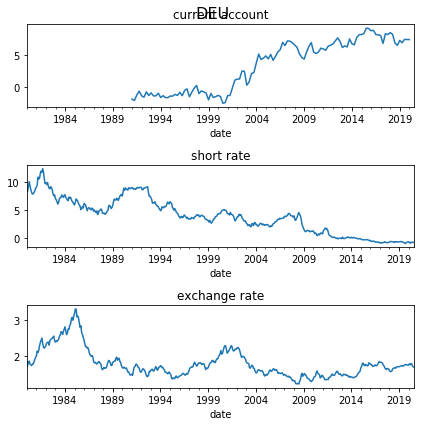

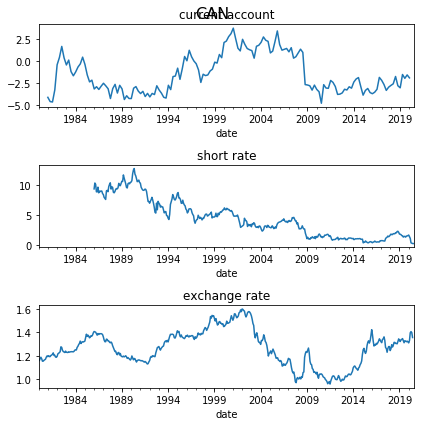

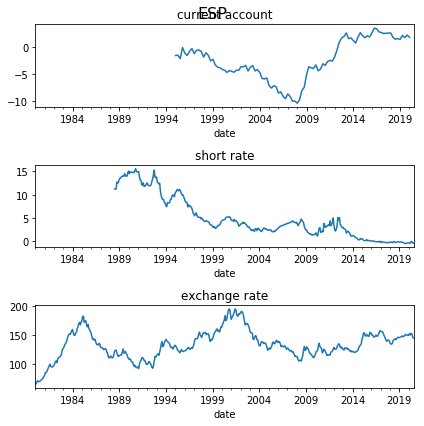

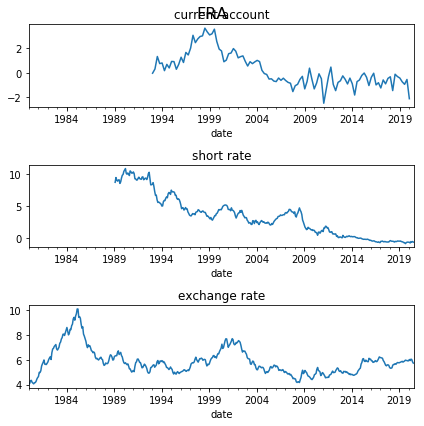

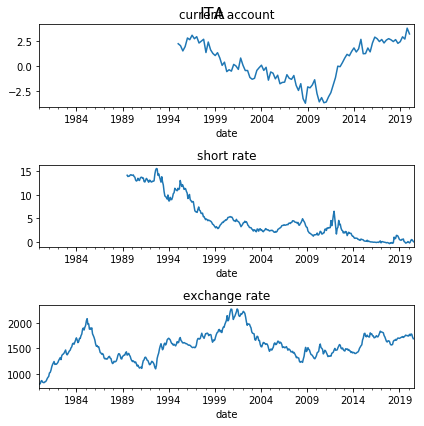

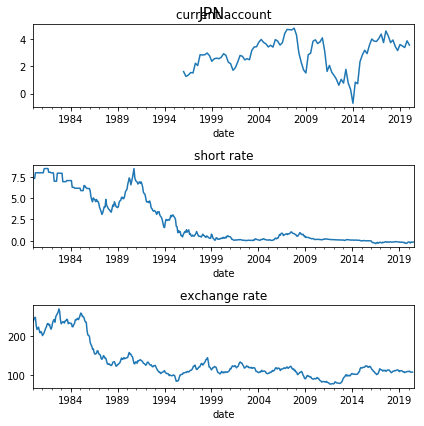

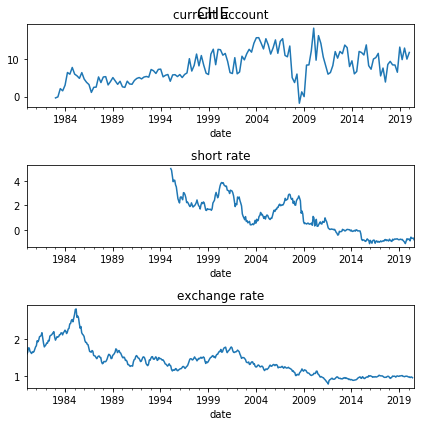

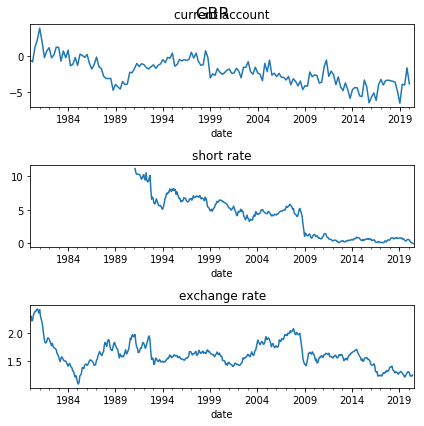

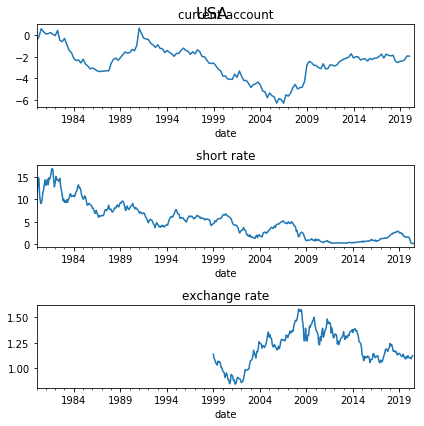

In [17]:
CurrAcctPctGDP = dl.pull("currAcctPctGDP")

for country in BondReturns.columns.values: 
    fig, axs = plt.subplots(3, 1, figsize=(6,6))
    fig.suptitle(country, fontsize=16)
    CurrAcctPctGDP[country].plot(ax=axs[0], title="current account")
    ShortRates[country].plot(ax=axs[1], title="short rate")
    FxVsUSD[country].plot(ax=axs[2], title="exchange rate")
    plt.tight_layout()
    plt.plot()

The prospectus says we tend to see either big interest rate increases or steep FX declines when the current account is persistently negative. 

This bears out in Australia because there are sharp upward spikes in the FX rate (i.e. depreciation of the AUD) after long periods of negative current account. 

This does not play out in USA. 

# Question 7 
Ignoring risk premium, we are going to try and show that economic growth and inflation changes are drivers of bond returns.

What should we expect? As GDP increases, an economy begins to experience inflation. Interest rates are increased which will hurt bond returns. Conversely, when GDP growth is low (and inflation is not a problem), interest rates will be decreased to stimulate the economy, increasing bond returns. 

In [77]:
# Let's get the RGDP change from quarter to quarter, annualized.  
CoreCPI = dl.pull("CoreCPI/SA")
RGDP = dl.pull("GDP/real")
BondReturns = dl.pull("BondRetIdx/LocalFX")

In [100]:
# Resample to quarterly changes. 
CoreCPIQoQ = CoreCPI.resample('Q').mean()
BondReturnsQoQ = BondReturns.resample('Q').mean()

In [101]:
# Get percentage change in these indicators. 
inflation_change = CoreCPIQoQ.pct_change()
returns_change = BondReturnsQoQ.pct_change()
rgdp_change = RGDP.pct_change()

In [125]:
# Calculate 5 year rolling averages for inflation and RGDP change. 
rgdp_rolling_ave = rgdp_change.rolling(5*QUARTERS_IN_YEAR).mean()
inflation_rolling_ave = inflation_change.rolling(5*QUARTERS_IN_YEAR).mean()
returns_rolling_ave = returns_change.rolling(QUARTERS_IN_YEAR).mean()

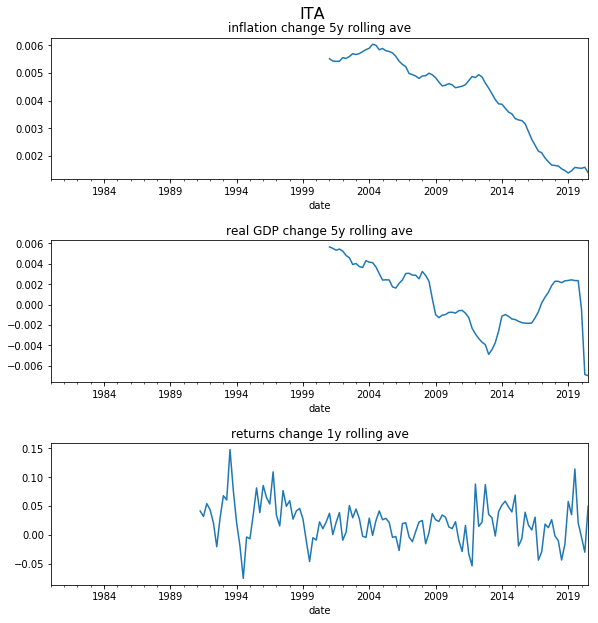

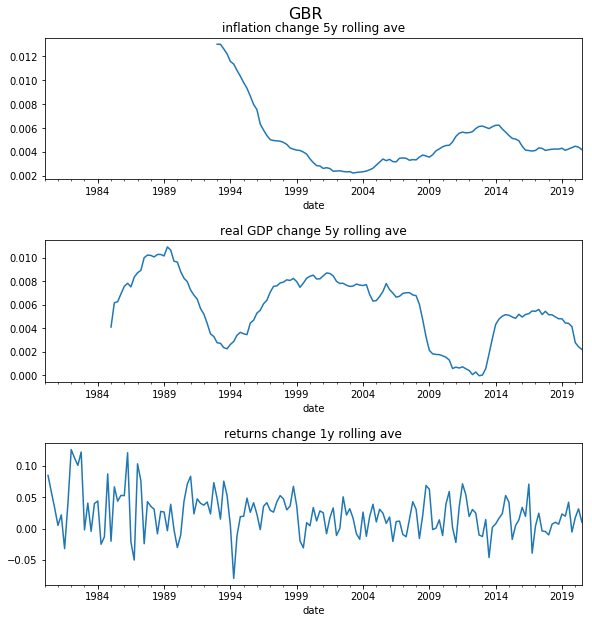

In [137]:
countries = ['ITA', 'GBR']
for country in countries:
    fig, axs = plt.subplots(3, 1, figsize=(9,9))
    fig.suptitle(country, fontsize=16)
    fig.tight_layout(pad=4)
    inflation_rolling_ave[country].plot(ax=axs[0], title="inflation change 5y rolling ave")
    rgdp_rolling_ave[country].plot(ax=axs[1], title="real GDP change 5y rolling ave")    
    returns_change[country].plot(ax=axs[2], title="returns change 1y rolling ave")

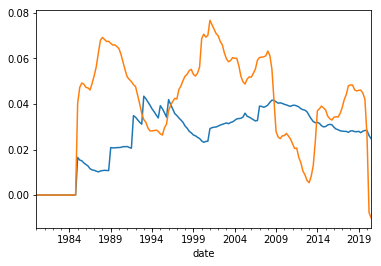

In [138]:
inflation_rolling_ave_sum = inflation_rolling_ave.sum(axis=1)
rgdp_rolling_ave_sum = rgdp_rolling_ave.sum(axis=1)
inflation_rolling_ave_sum.plot()
rgdp_rolling_ave_sum.plot()

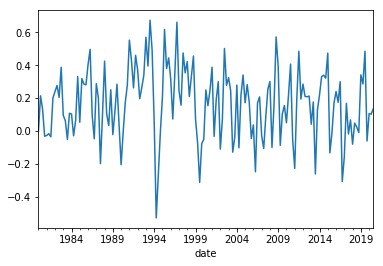

In [136]:
returns_change.sum(axis=1).plot()

# Question 8

# Question from Demo
### Calculate the rolling 1-year return of a world bond portfolio that is weighted by GDP of each country. Say that you instantly rebalance at the beginning of each quarter with the GDP from last quarter.

What do we need: real GDP, 

In [47]:
# Get the real GDP for all countries across time.
RGDP = dl.pull('GDP/real').dropna()
sums = RGDP.sum(1)

# Let's calculate some weights for every day based on GDP. 
weights = []
for i, row in enumerate(RGDP.iterrows()): 
    weights.append(row[1] / sums.iloc[i])
weights = pd.DataFrame(weights)
weights = weights.resample("B").ffill()

In [48]:
# Abbreviate the bond returns so we only have the range for which weights exist. 
AbbrBondReturns = BondReturns.loc[weights.index]

In [49]:
# Weight the returns. 
WeightedReturns = AbbrBondReturns * weights

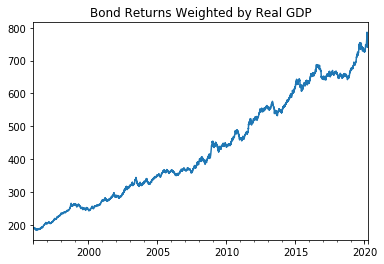

In [54]:
WeightedReturns.sum(axis=1).plot()
plt.title("Bond Returns Weighted by Real GDP")
plt.show()